<a href="https://colab.research.google.com/github/slp22/deep-learning-project/blob/main/dl_diabetic_retinopathy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Deep Learning | Model

# Diabetic Retinopathy<a id='top'></a> 

## Imports

In [ ]:
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import pandas as pd
import pathlib as Path
import pickle
import PIL
import random
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import warnings
import zipfile

from glob import glob
from IPython.display import SVG
from keras import backend as K
from keras import layers
from keras import regularizers, optimizers
from keras.applications import inception_v3, mobilenet_v2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import InputLayer, Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import model_to_dot
# from keras.utils.viz_utils import plot


from PIL import Image

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

%pylab inline
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']  # or svg
pd.set_option('display.max_colwidth', None)
sns.set(context='notebook', style='whitegrid')
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras Version:", tf.keras.__version__)
print("Scikit-learn version:", sk.__version__)


Populating the interactive namespace from numpy and matplotlib
Num GPUs Available:  1
Matplotlib version: 3.2.2
Numpy version: 1.21.6
Pandas version: 1.3.5
TensorFlow version: 2.8.2
Keras Version: 2.8.0
Scikit-learn version: 1.0.2


[Google Colabs](https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=23TOba33L4qf): `If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to Runtime > Change runtime type in the menu to enable a GPU accelerator, and then re-execute the code cell.`

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

## 1 | Research Design


* **Research Question:** How well can a neural network diagnose diabetic retinopathy from a retinal image?
* **Impact Hypothesis:** *The client, the [National Eye Institute](https://www.nei.nih.gov/), part of the National Institutes of Health, wants a model that can quickly identify [diabetic retinopathy](https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy) in patients participating in early phase [clinical trials](https://iovs.arvojournals.org/article.aspx?articleid=2565675).*
* **Data source:** [Diabetic Retinopathy 2015 Data Colored Resized](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized) , n=35,126
* **Error metric:** Accruary for model iteratoins, precision and recall for final model

* **Data Dictionary:**
  * Classes = 5 stages of diabetic retinopathy:
    * **Normal eye**
    * **Mild** Nonproliferative Retinopathy: Microaneurysms are visbile, small areas of balloon-like swelling in the retina's tiny blood vessels.
    * **Moderate** Nonproliferative Retinopathy: Some blood vessels that nourish the retina are blocked.
    * **Severe** Nonproliferative Retinopathy: More blocked blood vessels, depriving several areas of the retina of blood supply; retina sends signals to the body to grow new blood vessels for nourishment.
    * **Proliferative** Retinopathy: Advanced stage; new blood vessels are abnormal and fragile; grow along the retina and along the surface of the clear, vitreous gel that fills the inside of the eye.


## 2 | Dataset: [Diabetic Retinopathy Retinal Images](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)

### Download dataset from Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandralparedes","key":"746c1c655d0796973a3d3552fbcc97a5"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# assign to directory 
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
# download dataset from kaggle
! kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

100% 1.93G/1.94G [00:43<00:00, 51.9MB/s]
100% 1.94G/1.94G [00:43<00:00, 48.1MB/s]


In [ ]:
# unzip kaggle file
zip_ref = zipfile.ZipFile('diabetic-retinopathy-2015-data-colored-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

## 3 | Exploratory Data Analysis

### Data size and classes

In [ ]:
# show number of classes and images
source_images_path = '/tmp/colored_images/colored_images/'
extracted_directories_path = os.listdir(source_images_path)

for image_directory in extracted_directories_path:
  print(image_directory, len(os.listdir(os.path.join(source_images_path, image_directory))))

Severe 873
Moderate 5292
Proliferate_DR 708
No_DR 25810
Mild 2443


In [ ]:
filepath = '/tmp/colored_images/colored_images'
dataframe = {'image_path':[],'diagnosis':[]}

for diagnosis in os.listdir(filepath):
    print(diagnosis)
    if diagnosis != 'colored_images':        
        for image in os.listdir(filepath +"/"+diagnosis):
            if image != 'Dataset':
                dataframe['image_path'].append(filepath +"/"+diagnosis+"/"+ image)
                dataframe['diagnosis'].append(diagnosis)
dataframe = pd.DataFrame(dataframe)  
dataframe.info()
dataframe.head(2)

Severe
Moderate
Proliferate_DR
No_DR
Mild
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  35126 non-null  object
 1   diagnosis   35126 non-null  object
dtypes: object(2)
memory usage: 549.0+ KB


,image_path,diagnosis
0,/tmp/colored_images/colored_images/Severe/328_right.png,Severe
1,/tmp/colored_images/colored_images/Severe/44200_right.png,Severe


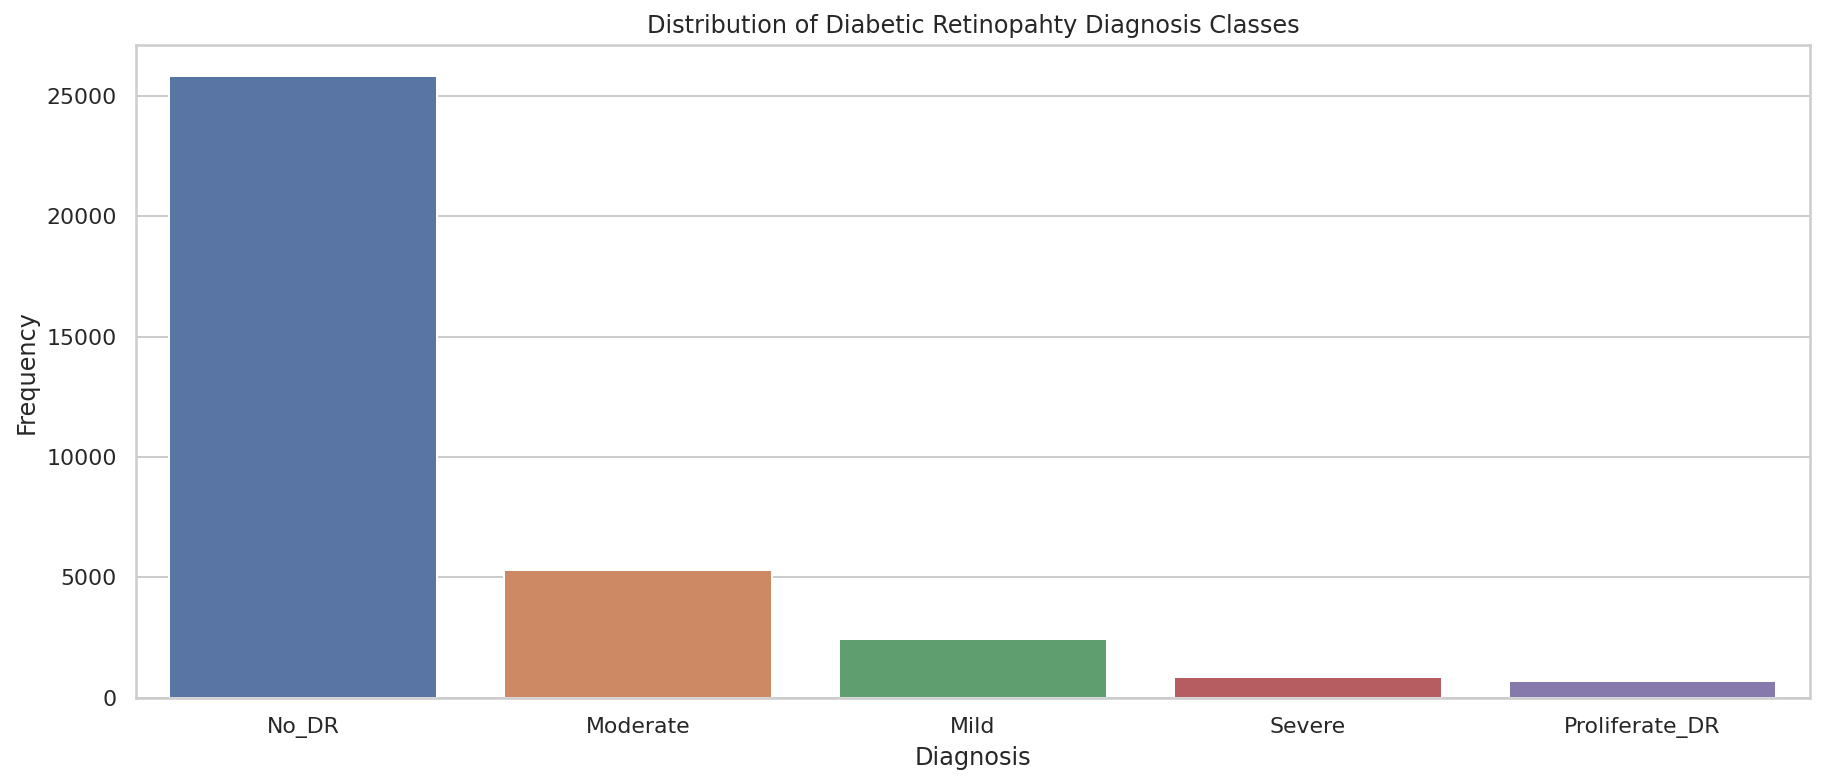

In [ ]:
# distribution of five diagnosis classes in order of severity of disease

plt.figure(figsize=(15,6))
sns.barplot(dataframe.diagnosis.value_counts().index,
            dataframe.diagnosis.value_counts(),
            palette=None)
plt.title("Distribution of Diabetic Retinopahty Diagnosis Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Frequency");


### Preview data

No Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


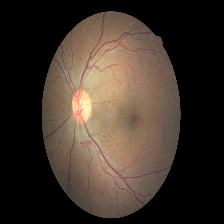

In [ ]:
# view one healthy eye image

path = '/tmp/colored_images/colored_images/No_DR/10003_left.png'

healthy_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256),
   interpolation="nearest")

print('No Diabetic Retinopthy')
print('Datatype:', type(healthy_image))
healthy_image 


Proliferate Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


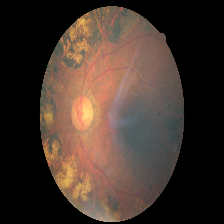

In [ ]:
# view one proliferate DR image (most advanced stage of disease)

path = '/tmp/colored_images/colored_images/Proliferate_DR/10017_left.png'

proliferate_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256), 
   interpolation="nearest")

print('Proliferate Diabetic Retinopthy')
print('Datatype:', type(proliferate_image))
proliferate_image 


### **Data Summary: n = 35,126;  unbalanced classes**

## 4 | Validation

### Set up test and train folders, split data, and move into class folders

In [ ]:
# set up for train/test split

temp_path = '/tmp'
raw_data_dir_name = 'raw_data'

train_data_dir_name = 'train'
test_data_dir_name = 'test'
raw_data_directories = [train_data_dir_name, test_data_dir_name]

images_path =  os.path.join(temp_path, raw_data_dir_name)
tmp_directories = os.listdir(temp_path)

def build_raw_data_directory(parent, directory):
  dir_path = os.path.join(parent, directory)
  os.mkdir(dir_path)
  for dir in extracted_directories_path:
    os.mkdir(os.path.join(dir_path, dir))

if raw_data_dir_name not in tmp_directories:
  os.mkdir(images_path)
  for directory in raw_data_directories:
    build_raw_data_directory(images_path, directory)
else:
  print(raw_data_dir_name, " already exist")
  images_path_directories = os.listdir(images_path)
  for directory in raw_data_directories:
    if directory not in images_path_directories:
      build_raw_data_directory(images_path, directory)

In [ ]:
## In case folder creation fails: 
### shutil.rmtree('/tmp/raw_data/train/')
### shutil.rmtree('/tmp/raw_data/test/')
### shutil.rmtree('/tmp/raw_data/')


In [ ]:
## split data into train/test folders

distribution = 0.2

raw_data_path = os.path.join(temp_path, raw_data_dir_name)
test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

data_dirs = os.listdir(source_images_path)

for dir in data_dirs:
  path = os.path.join(source_images_path, dir)
  test_data_path = os.path.join(test_data_path_root, dir)
  train_data_path = os.path.join(train_data_path_root, dir)
  images = os.listdir(path)
  print(path, test_data_path)
  for image in images:
    random_number = random.uniform(0, 1)
    is_test_image = random_number < distribution
    source_image_path = os.path.join(path, image)
    # shutil.copy(src, dst)
    if is_test_image:
      shutil.copy(source_image_path, test_data_path)
      # print(source_image_path, "goes to test", test_data_path)
    else:
      shutil.copy(source_image_path, train_data_path)
      # print(source_image_path, "goes to train", train_data_path)

test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

test_dirs = os.listdir(test_data_path_root)
train_dirs = os.listdir(train_data_path_root)

for dir in test_dirs:
  path = os.path.join(test_data_path_root, dir)
  files = os.listdir(path)
  print(path, len(files))

for dir in train_dirs:
  path = os.path.join(train_data_path_root, dir)
  files = os.listdir(path)
  print(path, len(files))

/tmp/colored_images/colored_images/Severe /tmp/raw_data/test/Severe
/tmp/colored_images/colored_images/Moderate /tmp/raw_data/test/Moderate
/tmp/colored_images/colored_images/Proliferate_DR /tmp/raw_data/test/Proliferate_DR
/tmp/colored_images/colored_images/No_DR /tmp/raw_data/test/No_DR
/tmp/colored_images/colored_images/Mild /tmp/raw_data/test/Mild
/tmp/raw_data/test/Severe 164
/tmp/raw_data/test/Moderate 1119
/tmp/raw_data/test/Proliferate_DR 141
/tmp/raw_data/test/No_DR 5191
/tmp/raw_data/test/Mild 502
/tmp/raw_data/train/Severe 709
/tmp/raw_data/train/Moderate 4173
/tmp/raw_data/train/Proliferate_DR 567
/tmp/raw_data/train/No_DR 20619
/tmp/raw_data/train/Mild 1941


### **Train (80%) and test (20%) folders**

## 5 | Baseline 

### Non-Deep Learning Model: Logistic Regression

### Set up data for logistic regression
Code adapted from [sdblass](https://github.com/sdblass/Metis_coursework/blob/master/6_Deep_Learning/2_baseline_model.ipynb)

In [ ]:
# create raw_data_small set to use in logistic regression model
original_raw_data_path = '/tmp/raw_data'
raw_data_copy = '/tmp/raw_data_small'
# shutil.copytree(original_raw_data_path, raw_data_copy)

raw_data_copy_test_path = '/tmp/raw_data_small/test'
raw_data_copy_train_path = '/tmp/raw_data_small/train'

# cull to keep 200 images from each class in raw_data_small
paths_to_reduce_images = [raw_data_copy_test_path, raw_data_copy_train_path]

for path in paths_to_reduce_images:
  dir_names = os.listdir(path)
  for dir_name in dir_names:
    images_path = os.path.join(path, dir_name)
    files = os.listdir(images_path)
    for index, file in enumerate(files):
      if index >= 200:
        file_path = os.path.join(images_path, file)
        os.remove(file_path)

In [ ]:
root = '/tmp/raw_data_small/train'
retinas = os.listdir(root)
retinas = [retina for retina in retinas if retina[0]!='.']

In [ ]:
# convert image to 1D vector
test_img_path = os.listdir(root+f'/{retinas[0]}')[0]
test_img_path = root+f'/{retinas[0]}' + f'/{test_img_path}'
test_img = Image.open(test_img_path)

In [ ]:
# num pixels
dimension = np.array(test_img).reshape(-1).shape[0]
dimension

150528

In [ ]:
# function to count images
def image_count(num_diagnoses, root): 
  num_images = 0
  for i, retina in enumerate(retinas):
    if i == num_diagnoses: break
    num_images += len(os.listdir(root + f'/{retina}'))
  return num_images

In [ ]:
# num images in raw_data_small; 5 classes (diagnoses) 
image_count(5, root) 

1000

In [ ]:
# # initialize 2D matrix with dimensions equal to num of images times num of pixels
# image_repo = np.zeros([image_count(5, root), dimension])
# image_repo

In [ ]:
# function to vectorize images in raw_data_small/train
def img_vectorization(num_diagnoses, root):
  image_repo = np.zeros([image_count(num_diagnoses, root), dimension])
  count = 0
  diagnosis = []
  for i, retina in enumerate(retinas):
    images = os.listdir(root + f'/{retina}')
    for image in images:
      img = Image.open(root + f'/{retina}' + f'/{image}')
      row = np.array(img).reshape(-1)
      image_repo[count, :] = row
      diagnosis.append(retina)
      img.close()
      count += 1
    if i == num_diagnoses - 1: 
      return image_repo, diagnosis
  return image_repo, diagnosis
# print(image_repo.shape)

In [ ]:
X_train, y_train_dx = img_vectorization(5, root)

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print('X train shape:', X_train.shape)
print('y train (dx) length:', len(y_train_dx))

X train shape: (1000, 150528)
y train (dx) length: 1000


In [ ]:
# vectorize raw_data_small/test data
root_test = '/tmp/raw_data_small/test'
X_test, y_test_dx = img_vectorization(5, root_test)

In [ ]:
print(X_test)
print(X_test.shape)
print(len(y_test_dx))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
(914, 150528)
914


In [ ]:
# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

type(X_train)

numpy.ndarray

### PCA

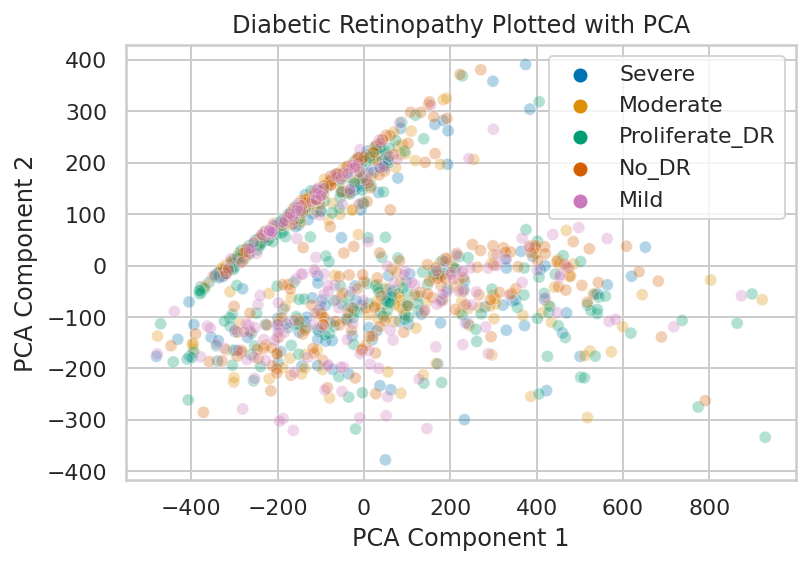

In [ ]:
# PCA 2 components
pca = PCA(n_components=2)
X_train_2PC = np.asarray(pca.fit_transform(X_train))
X_test_2PC = np.asarray(pca.transform(X_test))

sns.scatterplot(x=X_train_2PC[:, 0], 
                y=X_train_2PC[:, 1],
                hue=y_train_dx, 
                alpha=.3,
                palette=sns.color_palette("colorblind", 5))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Diabetic Retinopathy Plotted with PCA")
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/PCA.png' % (2));


In [ ]:
# logistic regression baseline with PCA
baseline_lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
baseline_lr.fit(X_train_2PC, y_train_dx)

score = baseline_lr.score(X_test_2PC, y_test_dx)
print('Logistic Regresion PCA Baseline Score = ', score)

Logistic Regresion PCA Baseline Score =  0.20350109409190373


### Truncated SVD


In [ ]:
# truncated SVD
svd = TruncatedSVD(n_components=2)
X_train_2d = svd.fit_transform(X_train)
X_test_2d = svd.transform(X_test)

print('X_train_2d', X_train_2d.shape)
print('X_test_2d', X_test_2d.shape)

X_train_2d (1000, 2)
X_test_2d (914, 2)


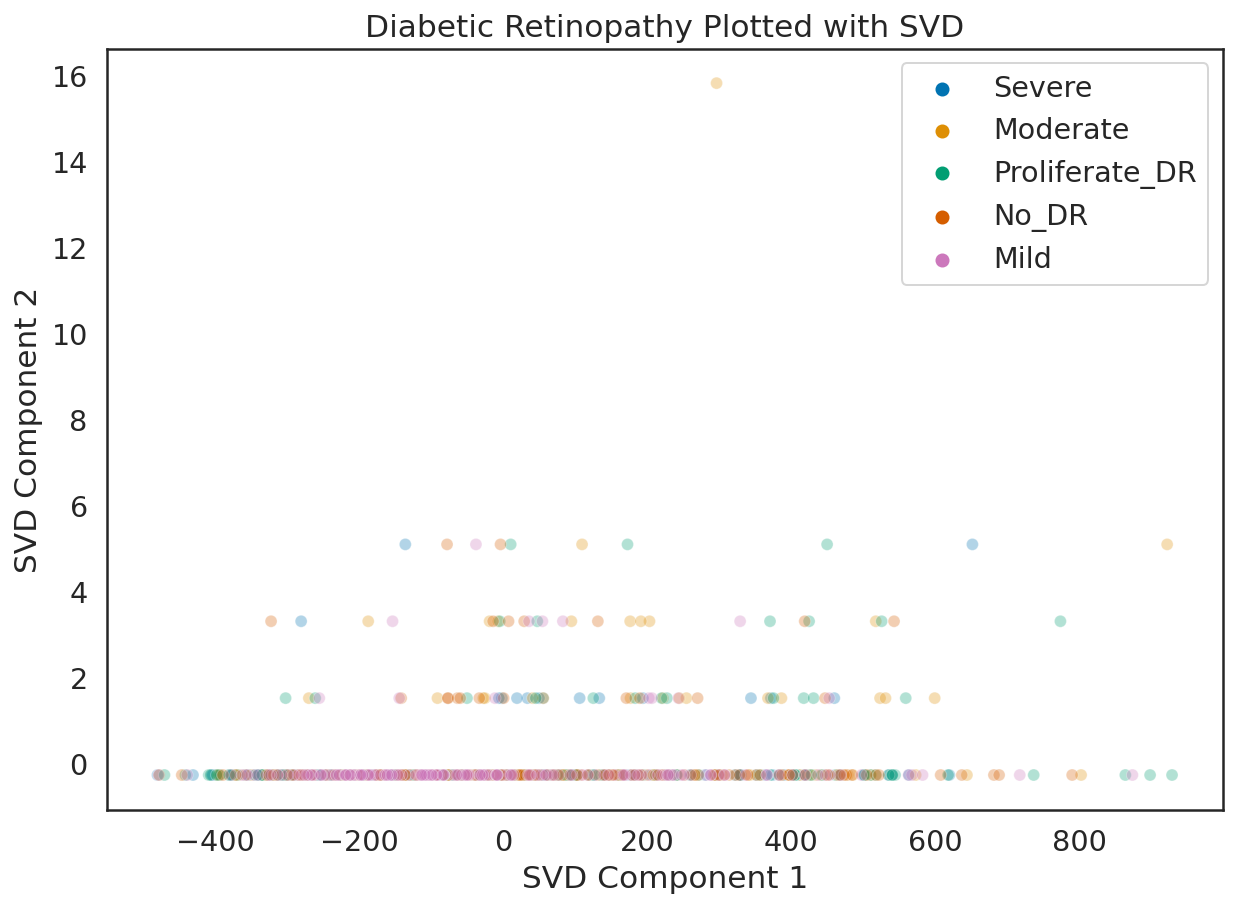

In [ ]:
#plot TruncatedSVD
sns.set(style='white', rc={"figure.figsize":(10, 7)}, font_scale=1.3)
sns.scatterplot(x=X_train_2d[:, 0], 
                y=X_train[:, 1],
                hue=y_train_dx, 
                alpha=.3,
                palette=sns.color_palette("colorblind", 5))
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("Diabetic Retinopathy Plotted with SVD");
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/TruncatedSVD.png' % (2));

In [ ]:
# logistic regression baseline with SVD
baseline_lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
baseline_lr.fit(X_train_2d, y_train_dx)

score = baseline_lr.score(X_test_2d, y_test_dx)
print('Logistic Regresion SVD Baseline Score = ', score)

Logistic Regresion SVD Baseline Score =  0.20350109409190373


### **Logistic regression scores poorly on accruacy for classifying diabetic retinopathy based on retinal images**
* PCA Baseline Score =  0.20350109409190373
* SVD Baseline Score =  0.20350109409190373


## 6 | Deep Learning Models

### ImageDataGenerator


Code adapted from [stackoverflow](https://stackoverflow.com/questions/61215270/input-shape-with-image-generator-in-tensorflow) and [medium](https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720) and [github/kasteway](https://github.com/kasteway/Road-_Sign_Classification/blob/main/CNN%20updated%20Initial%20Model.ipynb)

In [594]:
K.set_image_data_format('channels_last')
# any model loaded from Keras Apps will get built according to the TensorFlow data format convention, "Height-Width-Depth".

train_dir  = '/tmp/raw_data/train'
test_dir = '/tmp/raw_data/test'

img_width, img_height = 32, 32
input_shape = img_width, img_height, 3

train_samples = 2000
test_samples = 1000

train_datagen = ImageDataGenerator(
    rescale = 1. /255)

test_datagen = ImageDataGenerator(
    rescale = 1. /255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    seed=42)  

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    class_mode = 'categorical',
    seed=42)  


Found 28009 images belonging to 5 classes.
Found 7117 images belonging to 5 classes.


In [596]:
print(input_shape)

(32, 32, 3)


In [597]:
# https://expoundai.wordpress.com/2019/04/24/image-data-generators-in-keras/

print('num samples', train_data.samples)
print('num classes', len(train_data.class_indices))
print('num samples per class', int(train_data.samples/len(train_data.class_indices)))

num samples 28009
num classes 5
num samples per class 5601


In [598]:
print(train_data.class_indices)

{'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}


In [599]:
train_data.filenames[0:5]

['Mild/10030_left.png',
 'Mild/10030_right.png',
 'Mild/10085_left.png',
 'Mild/10085_right.png',
 'Mild/10150_right.png']

In [600]:
X_train, y_train = next(train_data)
print('X_train type', type(X_train))
print('y_train type', type(y_train))
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)

X_train type <class 'numpy.ndarray'>
y_train type <class 'numpy.ndarray'>
X_train shape (32, 32, 32, 3)
y_train shape (32, 5)


### 6.1 Neural Network

In [613]:
NN_model = Sequential()

NN_model.add(InputLayer(input_shape=input_shape))
NN_model.add(Flatten())
NN_model.add(Dense(units=10, activation="relu"))
NN_model.add(Dense(units=5, activation='softmax'))

NN_model.summary()

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_108 (Flatten)       (None, 3072)              0         
                                                                 
 dense_227 (Dense)           (None, 10)                30730     
                                                                 
 dense_228 (Dense)           (None, 5)                 55        
                                                                 
Total params: 30,785
Trainable params: 30,785
Non-trainable params: 0
_________________________________________________________________


In [614]:
NN_model.compile('sgd', 
                 loss='mean_absolute_error', 
                 metrics=['accuracy'])

In [615]:
history = NN_model.fit_generator(generator=train_data,
                                 steps_per_epoch=32, 
                                 epochs=5, 
                                 verbose=1)

Epoch 1/5
32/32 [==============================] - 2s 51ms/step - loss: 0.3049 - accuracy: 0.3633
Epoch 2/5
32/32 [==============================] - 2s 53ms/step - loss: 0.1834 - accuracy: 0.7490
Epoch 3/5
32/32 [==============================] - 2s 53ms/step - loss: 0.1477 - accuracy: 0.7109
Epoch 4/5
32/32 [==============================] - 2s 52ms/step - loss: 0.1337 - accuracy: 0.7139
Epoch 5/5
32/32 [==============================] - 2s 53ms/step - loss: 0.1256 - accuracy: 0.7197


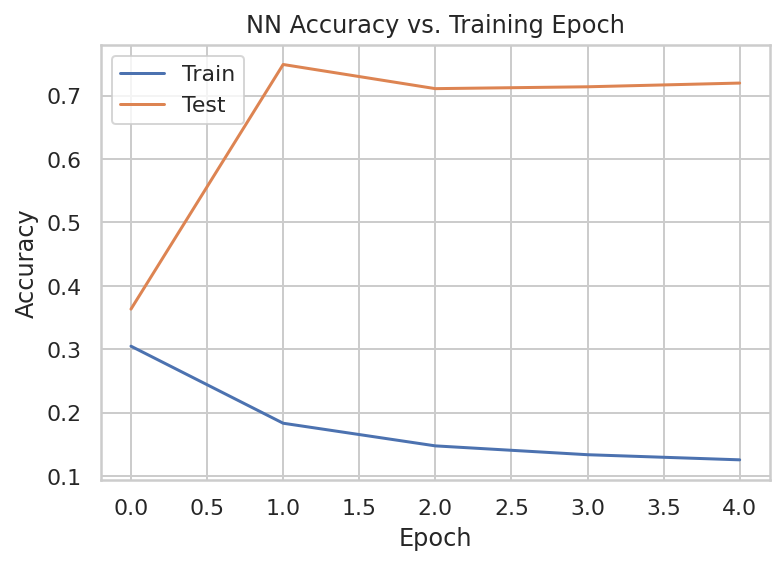

In [616]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

plt.title('NN Accuracy vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.savefig('NN_Accuracy_vs_Training_Epoch.png');

### 6. Convolutional Neural Network

In [617]:
print(input_shape)

(32, 32, 3)


In [ ]:
CNN_model = Sequential()

CNN_model.add(InputLayer(input_shape=(input_shape)))
CNN_model.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
CNN_model.add(MaxPooling2D())

CNN_model.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
CNN_model.add(MaxPooling2D())

CNN_model.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
CNN_model.add(MaxPooling2D())

CNN_model.add(Flatten())
CNN_model.add(Dense(1028, activation='softmax')) 
CNN_model.add(Dense(5, activation='softmax')) 

In [ ]:
CNN_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

In [632]:
# STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
# STEP_SIZE_TEST = test_data.n//test_data.batch_size

history = CNN_model.fit_generator(generator=train_data,
                                  steps_per_epoch=32,
                                  validation_data=test_data,
                                  validation_steps=32, 
                                  epochs= 20)

Epoch 1/20
32/32 [==============================] - 4s 116ms/step - loss: 0.9322 - accuracy: 0.7203 - val_loss: 0.9051 - val_accuracy: 0.7119
Epoch 2/20
32/32 [==============================] - 3s 107ms/step - loss: 0.8660 - accuracy: 0.7256 - val_loss: 0.8455 - val_accuracy: 0.7471
Epoch 3/20
32/32 [==============================] - 3s 108ms/step - loss: 0.8374 - accuracy: 0.7432 - val_loss: 0.9235 - val_accuracy: 0.6963
Epoch 4/20
32/32 [==============================] - 3s 108ms/step - loss: 0.8421 - accuracy: 0.7402 - val_loss: 0.9040 - val_accuracy: 0.7080
Epoch 5/20
32/32 [==============================] - 3s 107ms/step - loss: 0.8780 - accuracy: 0.7305 - val_loss: 0.8452 - val_accuracy: 0.7471
Epoch 6/20
32/32 [==============================] - 3s 110ms/step - loss: 0.8394 - accuracy: 0.7578 - val_loss: 0.7933 - val_accuracy: 0.7627
Epoch 7/20
32/32 [==============================] - 3s 108ms/step - loss: 0.8643 - accuracy: 0.7363 - val_loss: 0.8869 - val_accuracy: 0.7148
Epoch 

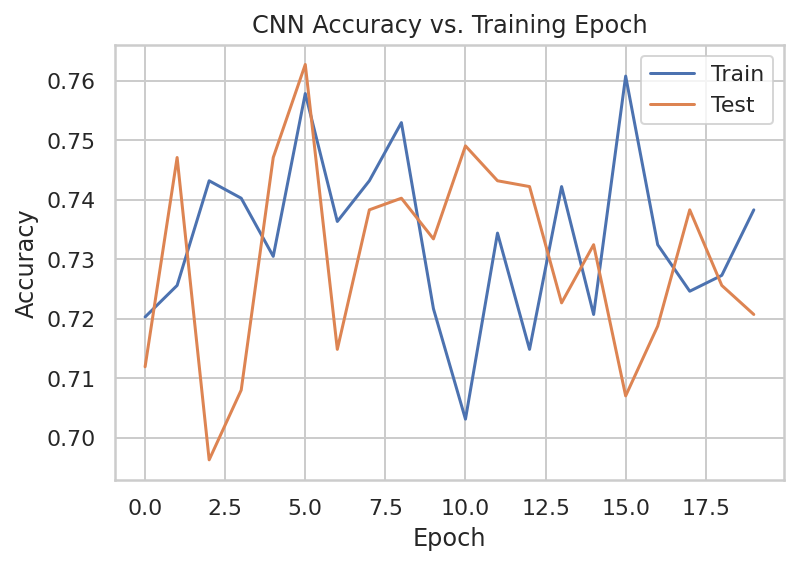

In [633]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('CNN Accuracy vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.savefig('CNN_Accuracy_vs_Training_Epoch.png');

In [ ]:
                              # callbacks=[EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
                              #            ReduceLROnPlateau(factor=.5, patience=3, verbose=1)]) 

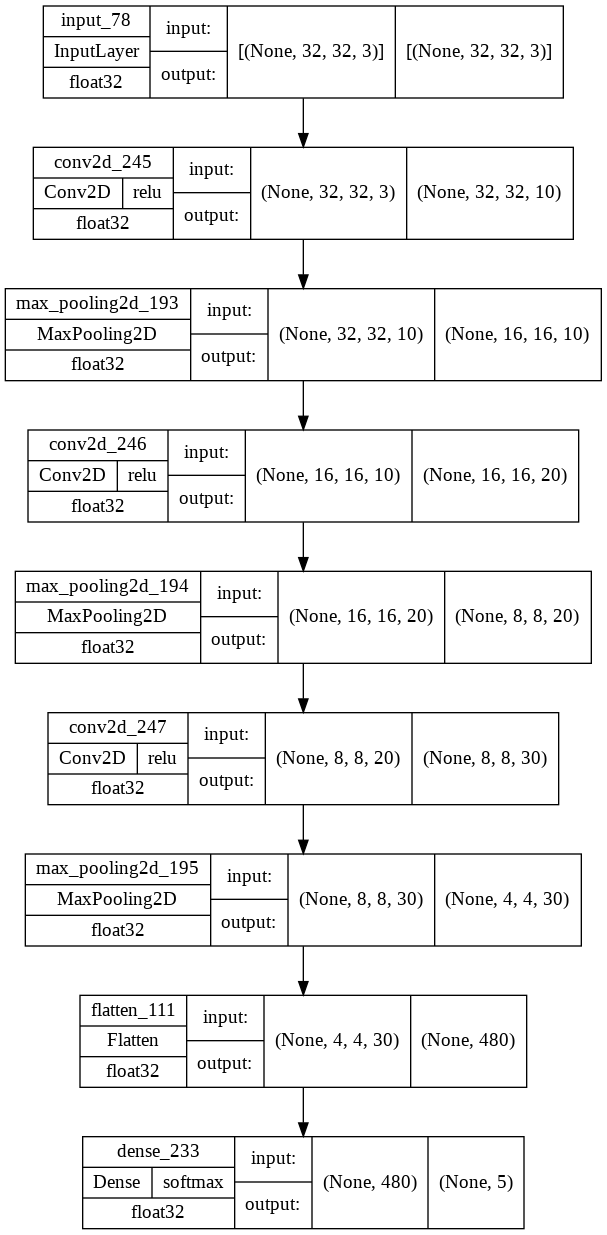

In [634]:
# show model 

tf.keras.utils.plot_model(
    CNN_model,
    to_file="CNN_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

### **NN and CNN scores poorly on accruacy for classifying diabetic retinopathy based on retinal images**
* accuracy = ***???**
* val_accuracy = **???**


### predict

In [ ]:
# STEP_SIZE_TEST = test_data.n//test_data.batch_size

# test_data.reset()

# pred = model.predict_generator(test_data,
#                                steps=STEP_SIZE_TEST,
#                                verbose=1)

222/222 [==============================] - 13s 61ms/step


In [ ]:
# predicted_class_indices=np.argmax(pred,axis=1)
# predicted_class_indices

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# labels = (train_data.class_indices)
# labels = dict((v,k) for k,v in labels.items())

# predictions = [labels[k] for k in predicted_class_indices]

# len(predictions) #7104

7104

In [ ]:
# # predict 

# # https://stackoverflow.com/questions/45806669/how-to-use-predict-generator-with-imagedatagenerator

# predict = model.predict_generator(test_data)

# type(predict) #numpy array, len=7117

In [ ]:
# filenames = test_data.filenames

# # results = pd.DataFrame({"Filename": filenames, "Predictions": predictions})

# # results.to_csv("results.csv",index=False)
# # len(filenames)

# len(filenames) #7117

7117

### MobileNet https://keras.io/api/applications/mobilenet/

### 6.2 Apply transfer learning

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

vgg_model = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

vgg_model.trainable = False

layer0 = tf.keras.layers.Flatten(name='flatten')(vgg_model.output)
layer1 = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(layer0)
layer2 = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(layer1)
layer3 = tf.keras.layers.Dense(5, activation='softmax')
vgg_model.summary() 

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    name="Adam")

vgg_model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN =  32#train_data.n//train_data.batch_size
STEP_SIZE_TEST = 32 #test_data.n//test_data.batch_size

history = vgg_model.fit_generator(generator=train_data,
                              steps_per_epoch=32,
                              validation_data=test_data,
                              validation_steps=32)
                              

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.savefig('Accuracy_vs_Training_Epoch.png');

In [ ]:
# def prepare_image(img_path):

#     img = image.load_img(img_path, target_size=(224, 224))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = mobilenet_v2.preprocess_input(x)
#     return x

In [ ]:
# ### Save X_digit, y_digit
# image_data_array = (X_train, X_test,X_val,y_train,y_test,y_val)
# with open('image_data_array.pickle','wb') as file:
#     pickle.dump(image_data_array,file)

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# # This is all we need to load and use the full pretrained model!
# model = mobilenet_v2.MobileNetV2(weights='imagenet',)

# x = prepare_image('???') #update this path if your image folder is in a different directory than the notebook!
# # df = pd.read_csv(io.BytesIO(
# #     uploaded['dog.jpeg']))
# # df.head()
# out = model.predict(x)

# print('Predicted:', mobilenet_v2.decode_predictions(out))

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# x = prepare_image('???')

# out = model.predict(x)

# print('Predicted:', mobilenet_v2.decode_predictions(out))

In [ ]:
# # https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb
#   acc = history.history['acc']
#   val_acc = history.history['val_acc']
#   loss = history.history['loss']
#   val_loss = history.history['val_loss']

### Transfer learning on pretrained base

In [ ]:
# # from tensorflow.keras.models import Model

# # note we exclude the final dense layers by setting include_top=False,
# # and add new ones to train from scratch below
# base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# # Freeze convolutional layers
# for layer in base_model.layers:
#     layer.trainable = False    

# # Establish new fully connected block
# x = base_model.output
# x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dense(50, activation='relu')(x)
# predictions = Dense(5, activation='softmax')(x) # should match # of classes predicted

# # define formal model object to train and compile it as usual
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['precision', 'recall'])

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# # i.e. if we had training images and our own labels, we could run
# model.fit(X_train,y_train)

## 7 | Model: Diagnosiing Diabetic Retinopathy

### Test Model

### Confusion Matrix

### Classification Report 

### Predictions

In [ ]:
# # https://www.tensorflow.org/tutorials/images/classification


# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# img = tf.keras.utils.load_img(
#     sunflower_path, target_size=(img_height, img_width))
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
# # https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/4%20Modes%20%20Evaluation.ipynb

# index = np.random.choice(len(df_test_incorrect))
# print(index)
# #plt.figure(figsize= (12,8))
# path = df_test_incorrect.iloc[index,0]
# print(path,"\n")
# img = IMG.load_img(path)  
# x = IMG.img_to_array(img)  
# plt.imshow(x/np.max(x))
# plt.axis('off')


# # print('The plot is a :',int_category_map.get(y_test_incorrect[index]))
# # print('But classfied as a :',int_category_map.get(y_pred_incorrect[index]))

# print('The plot is a :',df_test_incorrect.iloc[index,1])
# print('But classfied as a :',df_test_incorrect.iloc[index,3])